# RDD

**回帰不連続デザイン**（regression discontinuity design: RDD）は、ある連続変数（running variable）上のある地点を閾値（threshold, cut off point）として処置割り当てが変わる状況を利用し、閾値の直前と直後における結果変数の差を、閾値周辺の対象における局所的な平均処置効果とするデザイン


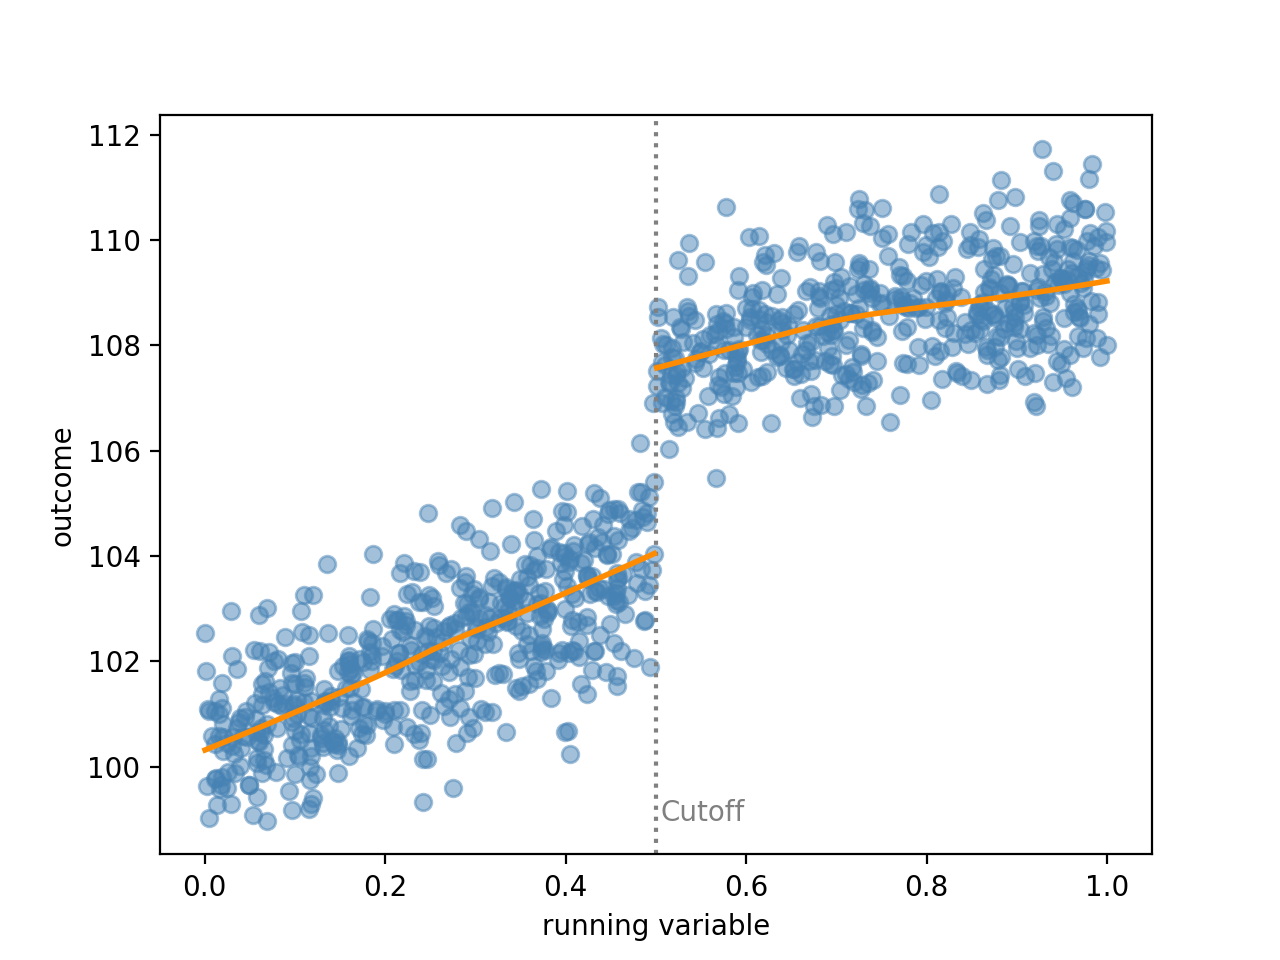

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

n = 1000
np.random.seed(0)
ate = 4
x = np.random.uniform(0, 1, size=n)
e = np.random.normal(size=n)
cutoff = 0.5
d = 1 * (x >= cutoff)
y = 100 + 10 * x + -5 * x**2 + ate * d + e
df = pd.DataFrame(dict(y=y, x=x, d=d))

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=.5, color="steelblue")
ax.set(xlabel="running variable", ylabel="outcome")
# sns.scatterplot(x="x", y="y", hue="d", data=df, ax=ax)

ax.axvline(x=cutoff, linestyle=":", color="gray")
ax.text(x=cutoff * 1.01, y=y.min(), s="Cutoff", color="gray")

import statsmodels.api as sm
for i in [0, 1]:
    preds = sm.nonparametric.lowess(y[d == i], x[d == i])
    ax.plot(preds[:, 0], preds[:, 1], linewidth=2, color="darkorange")

fig.show()

## RDDの分類

### 2つのframework

1. continuity-based framework: 分断点（cutoff point）付近のジャンプを見る
2. local randomization framework: 分断点付近のサンプルがたまたま分断点より高くなったか低くなったかはランダムと判断し、処置群と対照群を比較する


### 2つのdesign

1. Sharp RD: $X > c$のサンプルは100%の確率で処置を受ける
2. Fuzzy RD: $X > c$のサンプルは処置の確率が不連続に変化するが、100%ではない（処置割当に従わないことがありうる）


## Sharp RD Designs

Sharp RDDはすべての個体が確実に処置割り当てに従う（処置を受ける確率がcutoffで0から1へ不連続に変化する）というデザインである。

RDでは処置の割り当て$T$は、連続変数のrunning variable $X$が閾値（threshold; cutoff point）$c$を超えるかどうかにより決まる

$$
T = \mathbb{1}(X \geq c)
$$

continuity-basedの伝統的なsharp RD処置効果は次のように表される

$$
\tau_{SRD} := E[Y_i(1) - Y_i(0) | X_i=c]
= \lim_{x\downarrow c} E[Y_i|X_i=x] - \lim_{x\uparrow c} E[Y_i|X_i=x]
$$


$\lim_{x\downarrow c}$は$c$より大きい値から$c$に向けて$x$を近づけた極限（右極限）、$\lim_{x\uparrow c}$はその逆（左極限）


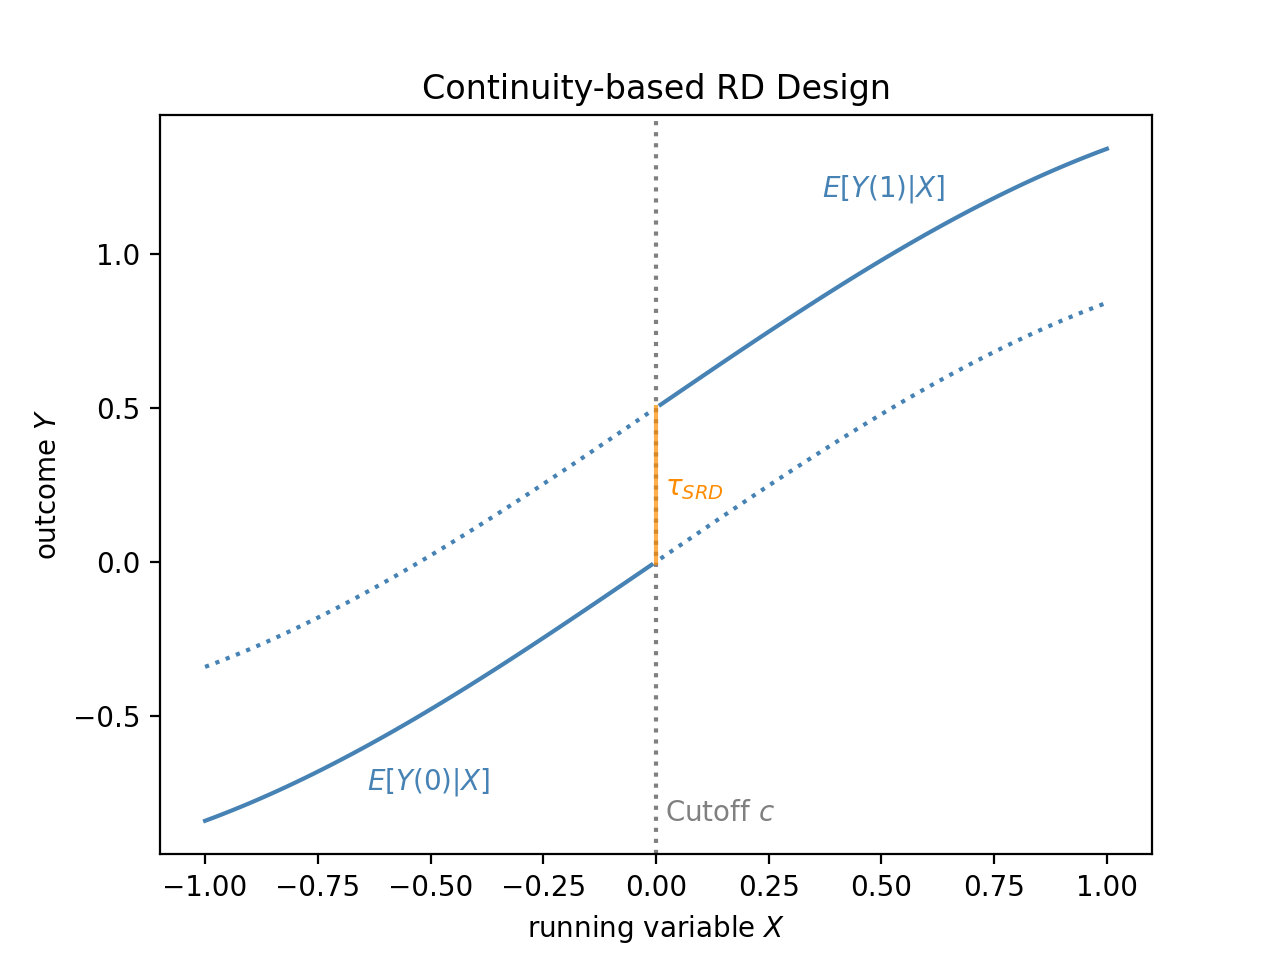

In [112]:
import numpy as np
import matplotlib.pyplot as plt

c = 0
x = np.linspace(-1, 1, 100)
d = (x > 0)
tau = 0.5
y = np.sin(x) + d * tau
y_unobserved = np.sin(x) + (1 - d) * tau

fig, ax = plt.subplots()
for i in [0, 1]:
    ax.plot(x[d == i], y[d == i], color="steelblue")
    ax.plot(x[d == i], y_unobserved[d == i], color="steelblue", linestyle=":")
    ax.text(x=x[d == i].mean(), y=y[d == i].mean() + (i * 0.3 + (1 - i) * -0.2),
            s=rf"$E[Y({i})|X]$", color="steelblue", ha="center", va="top")
    
ax.axvline(c, linestyle=":", color="gray")
ax.text(x=c + 0.02, y=y.min(), s=r"Cutoff $c$", color="gray", ha="left")

ax.vlines(x=c, ymin=y[d == 0].max(), ymax=y[d == 1].min(), color="darkorange", alpha=.7)
ax.text(x=c + 0.02, y=y[d == 0].max() + tau * 0.5, s=r"$\tau_{SRD}$", color="darkorange", ha="left", va="center")

ax.set(
    xlabel=r"running variable $X$",
    ylabel=r"outcome $Y$",
    title="Continuity-based RD Design"
)
fig.show()

## 線形RD

条件付き期待値$E[Y(1)|X], E[Y(0)|X]$がともに$X$に関して線形である場合、

$$
E[Y(1)|X] = \alpha_1 + \beta_1 X\\
E[Y(0)|X] = \alpha_0 + \beta_0 X
$$

と表すことができ、

$$
\tilde{\alpha}_1  = \alpha_1 + \beta_1 \cdot c\\
\tilde{\alpha}_0  = \alpha_0 + \beta_0 \cdot c\\
$$

と定義してすれば

$$
E[Y(1)|X] = \tilde{\alpha}_1 + \beta_1 (X - c)\\
E[Y(0)|X] = \tilde{\alpha}_0 + \beta_0 (X - c)
$$

と変形することができるため

$$
\begin{align}
\tau_{SRD}
&= E[Y(1)|X = c] - E[Y(0)|X = c]\\
&= \tilde{\alpha}_1 - \tilde{\alpha}_0
\end{align}
$$


のようにして線形回帰によってRD推定量を計算できる



## 多項式RD

条件付き期待値が非線形の場合で、線形回帰によって扱いたい場合は多項式でモデリングする方法がある

## 局所回帰

多項式よりはこちらが推奨される

## Fuzzy RD

処置の割当$T = \mathbb{1}(X \geq c)$に対して実際に処置を受けるかどうかを$D(T) \in \{0, 1\}$で表す。

処置が強制ではない場合でも、処置を受ける確率$P(D=1|X)$が$X=c$において不連続であればFuzzy RDによってRDによる推定ができる

continuity-based frameworkにおいて、Fuzzy RDのedtimandは次のように表される

$$
\tau_{FRD} = \frac
{ \lim_{x\downarrow c} E[Y_i|X_i=x] - \lim_{x\uparrow c} E[Y_i|X_i=x] }
{ \lim_{x\downarrow c} E[D_i|X_i=x] - \lim_{x\uparrow c} E[D_i|X_i=x] }
$$



## Pythonによる推定

`{rdrobust}`パッケージはRだけでなくPython版も提供されている（[RDROBUST · RD Packages](https://rdpackages.github.io/rdrobust/)）ので使っていく


In [2]:
from rdrobust import rdrobust, rdbwselect, rdplot

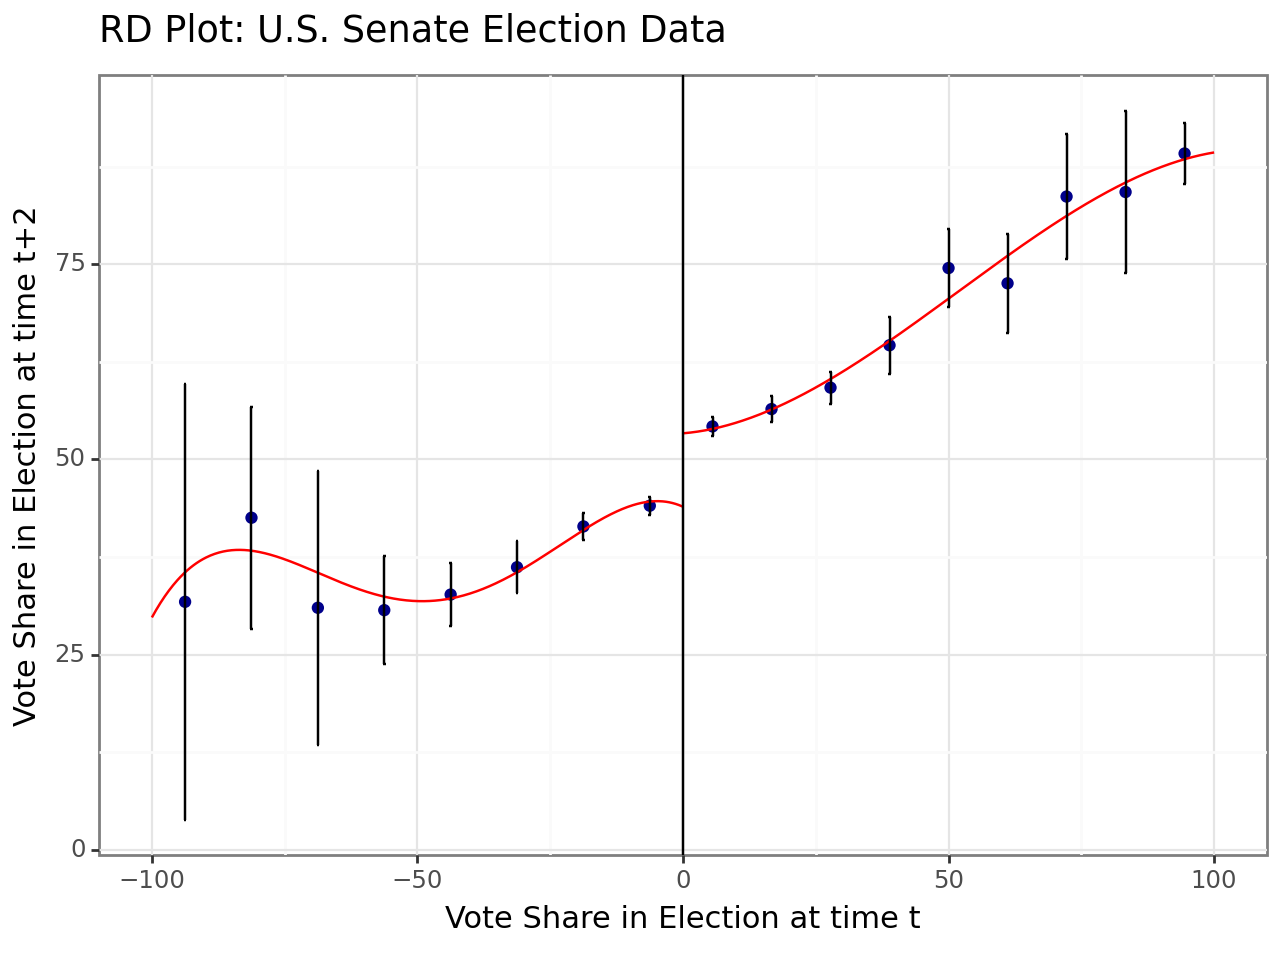


Call: rdplot
Number of Observations:                  1297
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Effective Obs          595        702
Bandwith poly. fit (h)         100.0      100.0
Number of bins scale               1          1
Bins Selected                      8          9
Average Bin Length              12.5     11.111
Median Bin Length               12.5     11.111
IMSE-optimal bins                8.0        9.0
Mimicking Variance bins         15.0       35.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [3]:
from rdrobust import rdrobust, rdbwselect, rdplot
import pandas as pd

### Load data base
rdrobust_senate = pd.read_csv("https://raw.githubusercontent.com/rdpackages/rdrobust/master/Python/rdrobust_senate.csv")

# Define the variblrs
margin = rdrobust_senate.margin
vote = rdrobust_senate.vote

### rdplot with 95% confidence intervals
rdplot(y=vote, x=margin, binselect="es", ci=95, 
         title="RD Plot: U.S. Senate Election Data", 
         y_label="Vote Share in Election at time t+2",
         x_label="Vote Share in Election at time t")


## Interrupted Time-Series

**分割時系列**（interrupted time-series）はRDDのrunning variableを時間にしたもの。
時系列特有の変動（自己相関性など）がバイアスになりうるので考慮が必要


例（医学系）：[Wagner, A. K., Soumerai, S. B., Zhang, F., & Ross‐Degnan, D. (2002). Segmented regression analysis of interrupted time series studies in medication use research. Journal of clinical pharmacy and therapeutics, 27(4), 299-309.](https://onlinelibrary.wiley.com/doi/10.1046/j.1365-2710.2002.00430.x/abstract;jsessionid=F03D81FDF2408F991F59B6E8BFD9606D.f01t02?systemMessage=Wiley+Online+Library+will+be+disrupted+on+16th+May+from+12%3A00-14%3A00+BST+%2807%3A00-09%3A00+EDT%29+for+up+to+two+hours+for+essential+maintenance.++Apologies+for+the+inconvenience.)

[Interrupted time series regression for the evaluation of public health interventions: a tutorial | International Journal of Epidemiology | Oxford Academic](https://academic.oup.com/ije/article/46/1/348/2622842)

## 参考文献

[RD Packages](https://rdpackages.github.io/)

### Introductions


- Cattaneo and Titiunik (2022): [Regression Discontinuity Designs](https://rdpackages.github.io/references/Cattaneo-Titiunik_2022_ARE.pdf).
  *Annual Review of Economics* 14: 821-851.
    - (arxiv) [Cattaneo, M. D., & Titiunik, R. (2022). Regression discontinuity designs.](https://arxiv.org/pdf/2108.09400.pdf)
- Cattaneo, Idrobo and Titiunik (2020): [A Practical Introduction to Regression Discontinuity Designs: Foundations](https://rdpackages.github.io/references/Cattaneo-Idrobo-Titiunik_2020_CUP.pdf).
  *Cambridge Elements: Quantitative and Computational Methods for Social Science*, Cambridge University Press. [Erratum](https://rdpackages.github.io/references/Cattaneo-Idrobo-Titiunik_2020_CUP--erratum.pdf).
- Cattaneo, Idrobo and Titiunik (2023): [A Practical Introduction to Regression Discontinuity Designs: Extensions](https://rdpackages.github.io/references/Cattaneo-Idrobo-Titiunik_2023_CUP.pdf).
  *Cambridge Elements: Quantitative and Computational Methods for Social Science*, Cambridge University Press.

### Multi-Cutoff

[Cattaneo, et al. (2021). Extrapolating treatment effects in multi-cutoff regression discontinuity designs.](https://arxiv.org/pdf/1808.04416.pdf)

### Multi-running variable?

[Abdulkadiroglu, A., Angrist, J. D., Narita, Y., & Pathak, P. A. (2019). Breaking ties: Regression discontinuity design meets market design.](https://www.mdc.e.u-tokyo.ac.jp/wp-content/uploads/2021/01/UTMD-003.pdf)